In [58]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display
import time
import imageio
import importlib

from sklearn import cluster, datasets, mixture
from sklearn.preprocessing import StandardScaler

In [2]:
# Step 1: Generate 3 Gaussians with the given centers & covariances 
def gen_distribution(means, covs, points_per_gauss):
    """ Generate 3 Gaussian distributions"""
    x0 = np.random.multivariate_normal(mean = means[0], cov = covs[0], size = points_per_gauss)
    x1 = np.random.multivariate_normal(mean = means[1], cov = covs[1], size = points_per_gauss)
    x2 = np.random.multivariate_normal(mean = means[2], cov = covs[2], size = points_per_gauss)
    
    y0 = []
    y1 = []
    y2 = []
    for i in range(0,points_per_gauss):
        y0.append([0])
        y1.append([1])
        y2.append([2])
        
    X = np.vstack([x0, x1, x2])
    c = np.vstack([y0, y1, y2])

    indices = np.arange(len(X))
    np.random.shuffle(indices)
    X = X[indices]
    c = c[indices]
    return X, c

In [73]:
class OnlineSNMF():
    def __init__(self, X, ydim, lamda=0.6, iterations=100):
        self.W = np.zeros((ydim, X.shape[1]))
        self.M = np.zeros((ydim, ydim))
        self.T = X.shape[0]
        self.X = X
        self.ydim = ydim
        self.iterations = iterations
        self.active_set = []
        self.ith_degree_used = np.zeros(ydim)
        self.lamda = lamda
        
        self.Y_store = np.zeros((self.ydim, self.T))
        self.X_store = X.T
        self.costs = []
        self.fname_list = []
        
    def adjust_weights(self, x_t, y_t, index, lamda = 0.6):
        """ Implement equation 5 """
        #print("Using equation 5")
        x_squared_norm = np.linalg.norm(x_t)**2
        y_squared = y_t * y_t
        #print(y_t.shape)

        test_condition = (x_squared_norm - np.sum(y_squared) + y_squared[index])

        if((test_condition ** 2) <= lamda):
            return 0
        else:
            if(test_condition < 0):
                return 0
            else:
                return np.sqrt(test_condition)
                   
    def update_weights(self, W, M, x_t, y_t, y_hat):
        """ Implement equation 8 """
        #y_hat += (y_t * y_t)
        #print("Using equation 8")
        y_dim = y_t.shape[0]

        x_t = x_t[np.newaxis, :]
        y_t = y_t[:, np.newaxis]

        dW = y_t @ (x_t - (self.W.T @ y_t).T)


        for i in range(self.ydim):
            if(y_hat[i] !=0):
                self.W[i] = self.W[i] + dW[i] / y_hat[i]

        dM = y_t @ (y_t.T - (self.M @ y_t).T)
        for i in range(self.M.shape[0]):
            dM[i][i] = 0

        for i in range(self.ydim):
            if(y_hat[i] !=0):
                self.M[i] = self.M[i] + dM[i] / y_hat[i]
        
    def fit_transform(self, plotting=False):
        y_hat = np.zeros(self.ydim)
        clusters = []
        
        for t in range(self.T): 
            x_t = self.X[t] 
            y_t = np.zeros(self.ydim) 
            #One-hot encoded (sort of - soft encoding not binary) 
            #  element Yt,i is non-zero if sample t is attributed to cluster i. --Quote from paper
            #Should scaling factor from eqn 3 be included? 
            for i in self.active_set:
                #Iterate till convergence -- convergence criteria not mentioned in paper for this algorithm
                #Ref. Code takes it as 100 steps? 
                for itr in range(self.iterations): 
                    y_ti = max(0, (self.W[i] @ x_t - self.M[i] @ y_t))
                y_t[i] = y_ti     
                
            for j in range(self.ydim):
                #Check all degrees of freedom
                #So far, this degree of freedom has not been used, then adjust weights by eqn 5;
                if(self.ith_degree_used[j] == 0):  
                    y_t[j] = self.adjust_weights(x_t, y_t, j, lamda=self.lamda)
                if(y_t[j]!=0):
                    self.ith_degree_used[j] = self.ith_degree_used[j] + 1
                if(j not in self.active_set and self.ith_degree_used[j] > 0):
                    self.active_set.append(j)
                
            # Compute cluster
            y_hat = y_hat + y_t * y_t
            self.Y_store[:, t] = y_t
            self.update_weights(self.W, self.M, x_t, y_t, y_hat)
            cluster = np.argmax(y_t)
            clusters.append(cluster)
            
            # Skip T = 0 since 0 cost
#             if t == 0:
#                 continue
        
            # Compute cost function
            YT = self.Y_store[:, 1:t+1]
            XT = self.X_store[:, 1:t+1]
            cost = np.linalg.norm(XT.T @ XT - YT.T @ YT, ord='fro') ** 2
            self.costs.append(cost)
        
            # Informative plotting/cool visualizations
            if plotting:
                if t % 10 == 0:
                    plt.figure(figsize=(5, 5))
                    plt.scatter(X[0:t+1, 0], X[0:t+1, 1], c=clusters)
                    plt.ylim([-2, 2])
                    plt.xlim([-2, 2])
                    plt.savefig('test/' + str(t) + '.png')
                    self.fname_list.append('test/' + str(t) + '.png')
                    plt.close()
        
        if plotting:
            with imageio.get_writer('test.gif', mode='I') as writer:
                for filename in self.fname_list:
                    image = imageio.imread(filename)
                    writer.append_data(image)
                
        return clusters
    
    def transform(self):
        """ Re-estimate data based on contributions up to time T"""
        clusters = []
        for t in range(self.T): 
            x_t = self.X[t] 
            y_t = np.zeros(self.ydim) 
            
            for i in self.active_set:
                #Iterate till convergence -- convergence criteria not mentioned in paper for this algorithm
                #Ref. Code takes it as 100 steps? 
                for itr in range(self.iterations): 
                    y_ti = max(0, (self.W[i] @ x_t - self.M[i] @ y_t))
                y_t[i] = y_ti    
                
            cluster = np.argmax(y_t)
            clusters.append(cluster)
        return clusters

In [92]:
# Reference: https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html
n_samples = 1000
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=0.5, noise=0.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(
    n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state
)

data = [
    (
        noisy_circles,
        {
            "damping": 0.77,
            "preference": -240,
            "quantile": 0.2,
            "n_clusters": 2,
            "min_samples": 20,
            "xi": 0.25,
        },
    ),
    (noisy_moons, {"damping": 0.75, "preference": -220, "n_clusters": 2}),
    (
        varied,
        {
            "eps": 0.18,
            "n_neighbors": 2,
            "min_samples": 5,
            "xi": 0.035,
            "min_cluster_size": 0.2,
        },
    ),
    (
        aniso,
        {
            "eps": 0.15,
            "n_neighbors": 2,
            "min_samples": 20,
            "xi": 0.1,
            "min_cluster_size": 0.2,
        },
    ),
    (blobs, {}),
    (no_structure, {}),
]

<ipython-input-73-38339034318a>:51: RuntimeWarning: overflow encountered in matmul
  dM = y_t @ (y_t.T - (self.M @ y_t).T)
<ipython-input-73-38339034318a>:73: RuntimeWarning: invalid value encountered in matmul
  y_ti = max(0, (self.W[i] @ x_t - self.M[i] @ y_t))
<ipython-input-73-38339034318a>:51: RuntimeWarning: invalid value encountered in matmul
  dM = y_t @ (y_t.T - (self.M @ y_t).T)


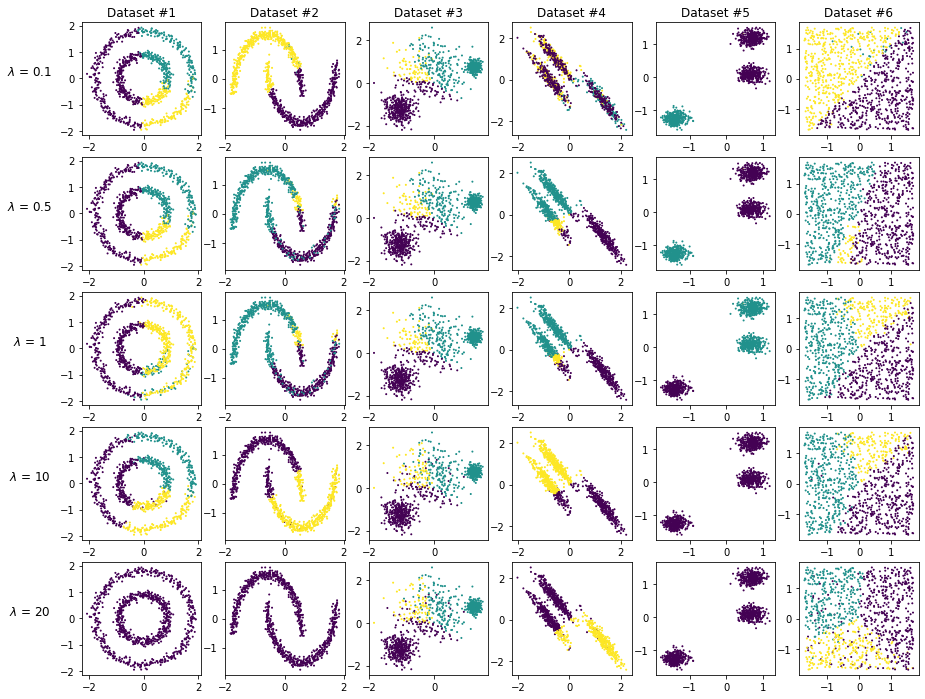

In [95]:
lamdas = [0.1, 0.5, 1, 10, 20]
fig, ax = plt.subplots(len(lamdas), 6, figsize=(15, 12))
for i_lamd, lamd in enumerate(lamdas):
    for i_dataset, (dat, algo_params) in enumerate(data):
        X, y = dat
        # normalize dataset for easier parameter selection
        X = StandardScaler().fit_transform(X)

        model = OnlineSNMF(X, 3, lamda=lamd, iterations=100)
        clusters = model.fit_transform()
        #clusters = model.transform()

        ax[i_lamd, i_dataset].scatter(X[:,0], X[:,1], c=clusters, s=1)
        
for i in range(len(lamdas)):
    ax[i, 0].set_ylabel('$\lambda$ = {}'.format(lamdas[i]), rotation=0, size='large', labelpad=30)
    
for i in range(len(data)):
    ax[0, i].set_title('Dataset #{}'.format(i+1))
    
plt.savefig('plots/sklearn_clustering_exp.pdf')